In [1]:
!python3 -m pip install -U --pre yt-dlp[default]

from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Audio
import pandas as pd
import os
from tqdm.auto import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.1/166.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.2 MB/s eta 0:00:00


In [2]:
import torch
import torchaudio
from torchaudio.transforms import Resample

def chunk_audio(audio, chunk_size, overlap):
    """
    Function to chunk audio into smaller segments with a specified overlap.
    
    Args:
    - audio: torch.Tensor - Input audio waveform
    - chunk_size: int - Size of each audio chunk (in samples)
    - overlap: int - Number of samples to overlap between consecutive chunks
    
    Returns:
    - List of torch.Tensor - List of audio chunks
    """
    num_samples = audio.size(1)
    chunks = []
    start = 0
    
    while start < num_samples:
        end = min(start + chunk_size, num_samples)
        chunk = audio[:, start:end]
        chunks.append(chunk)
        start += chunk_size - overlap
        
    return chunks



In [3]:
# Utility functions
def show_audio(frame,sample_rate=16000,title=''):
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(111)
    ax1.set_title('Raw wave ' + title)
    ax1.set_ylabel('Amplitude')
    ax1.set_xlabel('Second')
    timestamps=(np.linspace(1,len(frame),len(frame))-1)*(1/sample_rate)
    ax1.plot(timestamps, frame)

In [4]:
# !pip install -q torchaudio
# SAMPLING_RATE = 16000

import torch
torch.set_num_threads(1)

from IPython.display import Audio
from pprint import pprint
# download example
# torch.hub.download_url_to_file('https://models.silero.ai/vad_models/en.wav', 'en_example.wav')

USE_ONNX = False # change this to True if you want to test onnx model
if USE_ONNX:
    !pip install -q onnxruntime
  
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=USE_ONNX)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

/opt/conda/lib/python3.10/site-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


In [5]:
# Example usage
# Load audio
# Define parameters

SAMPLING_RATE = 16000
CLIP_DURATION = 10 #seconds
CHUNK_SIZE = SAMPLING_RATE*CLIP_DURATION  # Number of samples per chunk
OVERLAP = 0     # Number of samples to overlap between consecutive chunks
THRESH_SPEECH_DURATION_RATIO = 0.5

In [6]:
from glob import glob
paths = glob('/kaggle/input/yt-speech/renamed_files/*.wav')
print(len(paths))
print(paths[:3])

2
['/kaggle/input/yt-speech/renamed_files/000000.wav', '/kaggle/input/yt-speech/renamed_files/000001.wav']


In [7]:
waveform, sample_rate = torchaudio.load(paths[0])
waveform_mono = torch.mean(waveform, dim=0).unsqueeze(0)
print('Original sample_rate', sample_rate)

# Resample to 16 kHz
resampler = Resample(orig_freq=sample_rate, new_freq=SAMPLING_RATE)
resampled_waveform = resampler(waveform_mono)
# print('approx chunks', resampled_waveform.shape[1]//CHUNK_SIZE)

# Chunk the audio
audio_chunks = chunk_audio(resampled_waveform, CHUNK_SIZE, OVERLAP)

# Check the number of chunks
print("Number of chunks:", len(audio_chunks))

Original sample_rate 48000
Number of chunks: 296


In [8]:
sample = audio_chunks[40][0,:]

In [9]:
Audio(sample.numpy(), rate=SAMPLING_RATE)    

In [10]:
speech_timestamps = get_speech_timestamps(sample, model, sampling_rate=SAMPLING_RATE)
pprint(speech_timestamps)

[{'end': 18912, 'start': 2592},
 {'end': 120800, 'start': 26656},
 {'end': 160000, 'start': 128544}]


speech_duration ratio 0.8869999999999999


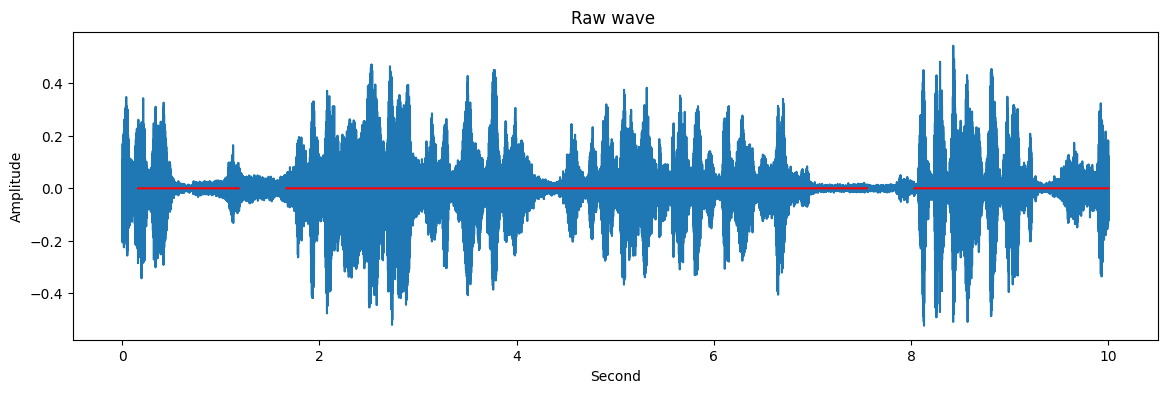

In [11]:
show_audio(sample,SAMPLING_RATE,title='')
speech_duration = 0
for item in speech_timestamps:
    speech_duration += (item['end']-item['start'])/SAMPLING_RATE
    time_range = np.arange(item['start'], item['end'])/SAMPLING_RATE
    plt.plot(time_range, [audio_chunks[15][0,:].mean().item()]*len(time_range), color = 'red')
print('speech_duration ratio', speech_duration/CLIP_DURATION)

In [12]:
os.makedirs('chunks', exist_ok = True)

In [13]:
root_audio = []
chunk_filename = []
speech_duration_list = []
for p in tqdm(paths):
    waveform, sample_rate = torchaudio.load(p)
    waveform_mono = torch.mean(waveform, dim=0).unsqueeze(0)
    print(p, 'duration (sec)', waveform.shape[1]/sample_rate)
    # Resample to 16 kHz
    resampler = Resample(orig_freq=sample_rate, new_freq=SAMPLING_RATE)
    resampled_waveform = resampler(waveform_mono)
    # Chunk the audio
    audio_chunks = chunk_audio(resampled_waveform, CHUNK_SIZE, OVERLAP)

    # Check the number of chunks
    print("Number of chunks:", len(audio_chunks))
    
    chunk_counter_per_audio = 0
    for i_c, chunk in enumerate(tqdm(audio_chunks)):
        speech_timestamps = get_speech_timestamps(chunk, model, sampling_rate=SAMPLING_RATE)
        speech_duration = 0
        for item in speech_timestamps:
            speech_duration += (item['end']-item['start'])/SAMPLING_RATE
        if speech_duration/CLIP_DURATION>=THRESH_SPEECH_DURATION_RATIO:
            chunk_counter_per_audio+=1
            root_audio_flname = os.path.basename(p)
            root_audio.append(root_audio_flname)
            i_p = root_audio_flname.replace('.wav', '')
            filename = '{}_{:06d}.wav'.format(i_p,i_c)
            speech_duration_list.append(speech_duration)
            chunk_filename.append(filename)
            torchaudio.save('/kaggle/working/chunks/'+filename, chunk, sample_rate=SAMPLING_RATE)
    print('Accepted number of chunks', chunk_counter_per_audio)
    

metadata = pd.DataFrame(
    {
        'root_audio': root_audio,
        'chunk_filename': chunk_filename,
        'speech_duration': speech_duration_list
    }
)
metadata.to_csv('chunks_metadata.csv', index = False)

  0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/yt-speech/renamed_files/000000.wav duration (sec) 2959.1253333333334
Number of chunks: 296


  0%|          | 0/296 [00:00<?, ?it/s]

Accepted number of chunks 277
/kaggle/input/yt-speech/renamed_files/000001.wav duration (sec) 2844.0148958333334
Number of chunks: 285


  0%|          | 0/285 [00:00<?, ?it/s]

Accepted number of chunks 265


In [14]:
print('total chunks', len(metadata))

total chunks 542
